Mejores parámetros (LR): {'lr__C': 0.05, 'lr__class_weight': None, 'lr__l1_ratio': 0.8, 'lr__penalty': 'elasticnet'}
Mejor CV Accuracy (train): 0.3395
TEST Accuracy: 0.339 | TEST Error: 0.661

Classification report (test):
               precision    recall  f1-score   support

    Abnormal       0.35      0.73      0.47       691
Inconclusive       0.29      0.12      0.17       656
      Normal       0.35      0.15      0.21       653

    accuracy                           0.34      2000
   macro avg       0.33      0.33      0.28      2000
weighted avg       0.33      0.34      0.29      2000



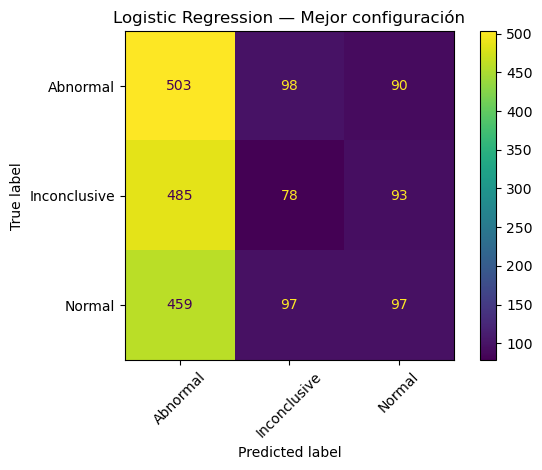

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
%matplotlib inline

# ---------- 1) Cargar datos ----------
# Cambia esta ruta si es necesario (Colab: sube el archivo y usa el nombre)
df = pd.read_csv("https://github.com/ulewis/Ejemplos/raw/main/Datos/healthcare_dataset.csv")

# ---------- 2) Ingeniería de features mínima ----------
# Fechas -> duración de estancia
for col in ["Date of Admission", "Discharge Date"]:
    df[col] = pd.to_datetime(df[col], errors="coerce")
df["LengthOfStayDays"] = (df["Discharge Date"] - df["Date of Admission"]).dt.days

# El target debe existir y ser categórico
target_col = "Test Results"
df = df.dropna(subset=[target_col]).copy()

# Selección de columnas: excluimos IDs y alta cardinalidad ("Hospital", "Doctor")
num_features = ["Age", "Billing Amount", "Room Number", "LengthOfStayDays"]
cat_features = [
    "Gender", "Blood Type", "Medical Condition",
    "Admission Type", "Insurance Provider", "Medication"
]

# Colapsar categorías raras para reducir ruido/sparsidad
def collapse_rare(series, min_frac=0.01):
    freq = series.value_counts(normalize=True, dropna=False)
    rare = freq[freq < min_frac].index
    return series.where(~series.isin(rare), other="__OTHER__")

for c in cat_features:
    df[c] = collapse_rare(df[c].astype(str), min_frac=0.01)

X = df[num_features + cat_features]
y = df[target_col].astype(str)  # etiquetas string

# ---------- 3) Split estratificado ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# ---------- 4) Preprocesamiento ----------
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

preprocess = ColumnTransformer([
    ("num", num_pipe, num_features),
    ("cat", cat_pipe, cat_features)
])

# ---------- 5) Modelo: Logistic Regression (multinomial, solver saga) ----------
base_lr = LogisticRegression(
    solver="saga",
    max_iter=5000,
    n_jobs=-1
)

pipe = Pipeline([
    ("prep", preprocess),
    ("lr", base_lr)
])

# ---------- 6) Búsqueda de hiperparámetros (solo LR) ----------
# Tres rejillas: l2, l1, elasticnet (saga soporta todas)
param_grid = [
    {
        "lr__penalty": ["l2"],
        "lr__C": [0.05, 0.1, 0.5, 1, 2, 5, 10],
        "lr__class_weight": [None, "balanced"]
    },
    {
        "lr__penalty": ["l1"],
        "lr__C": [0.05, 0.1, 0.5, 1, 2],
        "lr__class_weight": [None, "balanced"]
    },
    {
        "lr__penalty": ["elasticnet"],
        "lr__l1_ratio": [0.2, 0.5, 0.8],   # mezcla L1/L2
        "lr__C": [0.05, 0.1, 0.5, 1, 2],
        "lr__class_weight": [None, "balanced"]
    }
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    refit=True,
    verbose=0
)

grid.fit(X_train, y_train)

print("Mejores parámetros (LR):", grid.best_params_)
print("Mejor CV Accuracy (train):", round(grid.best_score_, 4))

# ---------- 7) Evaluación final en test ----------
y_pred = grid.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("TEST Accuracy:", round(acc, 4), "| TEST Error:", round(1-acc, 4))
print("\nClassification report (test):\n", classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation=45)
plt.title("Logistic Regression — Mejor configuración")
plt.tight_layout()
plt.show()